### Previsão de Mortes Neonatal

Neste projeto, vamos utilizar dados públicos do SINASC (Sistema de Nascidos Vivos) e do SIM (Sistema de Mortalidade) para construir modelos de aprendizado de máquina capazes de prever o risco de morte neonatal (até 28 dias após o nascimento).

*Alunos:*
- Júlia Moraes
- Luiz Eduardo

Imports necessários

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


#### 1. Tratamentos básico dos dados para ML

##### 1.1 Construindo matriz X e vetor y

In [2]:
df = pd.read_csv('sinasc_balanceado.csv', low_memory=False)

In [3]:
# dados númericos
num_cols = ['idade_mae', 'peso', 'semanas_gestacao', 'num_gestacao',
            'partos_normais', 'partos_cesareos', 'mes_inicio_prenatal', 'qntd_filvivos', 'qntd_filmortos']

# dados ordinais
ord_cols = ['consultas_prenatal', 'indice_kotelchuck', 'escolaridade_mae']

# dados categóricos
cat_cols = ['tipo_gravidez', 'tipo_parto', 'parto_induzido', 'cesarea_antes',
            'racacor_mae', 'racacor_bebe', 'paridade', 'anomalia_identificada',
            'doenca_epidemiologicas', 'doenca_nova',
            'prenatal_inadequado', 'poucas_consultas', 'prenatal_tardio']

In [4]:
# Transformar 9 ou outros ignorados em NaN
df.replace(9, pd.NA, inplace=True)

In [5]:
#Pipeline de pré-processamento

# Numéricas: imputar média e padronizar
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # valores vazios vira média
    ('scaler', StandardScaler()) # normaliza
])

# Ordinais: imputar mais frequente e codificar como dummies
ord_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # valores vazios vira moda
])

# Categóricas: imputar mais frequente e codificar dummies
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # valores vazios vira moda
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # codifica dummies
]) # exemplo: tipo_parto_vaginal, tipo_parto_cesarea recebe 0 ou 1 

# Combinar
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ord', ord_transformer, ord_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [6]:
y = df['obitos_1m']
X = df.drop(columns=['obitos_1m'])

In [7]:
# Verificar valores nulos nas colunas numéricas
print("Valores nulos nas colunas numéricas:")
for col in num_cols:
    if col in X.columns:
        print(f"{col}: {X[col].isnull().sum()}")

# Substituir pd.NA por np.nan para compatibilidade com sklearn
X = X.replace({pd.NA: np.nan})

Valores nulos nas colunas numéricas:
idade_mae: 2
peso: 29
semanas_gestacao: 585
num_gestacao: 1621
partos_normais: 2214
partos_cesareos: 2237
mes_inicio_prenatal: 2220
qntd_filvivos: 1714
qntd_filmortos: 2432


C:\Users\luize\AppData\Local\Temp\ipykernel_19516\1250505372.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({pd.NA: np.nan})


In [8]:
X_processed = preprocessor.fit_transform(X)

##### 1.2 Número de amostras e parametros 

In [9]:
N, p = X_processed.shape

print(f"Número de amostras (N): {N}")
print(f"Número de parâmetros (p): {p}")

Número de amostras (N): 44958
Número de parâmetros (p): 46


##### 1.3 Separar em treino e teste

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#### 2. REDES NEURAIS

In [12]:
BATCH_SIZE = 32
EPOCHS = 100
RANDOM_STATE = 2

In [35]:
# Criando a arquitetura da rede neural
model = Sequential()


model.add(Dense(64, input_dim=46, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(32, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(16,kernel_initializer='he_normal', activation='relu'))
model.add(Dense(1,kernel_initializer='he_normal', activation='sigmoid'))

# Instanciação e configuração de otimizadores
sgd = optimizers.SGD(learning_rate=0.01)

# Compila o modelo
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model.summary())

C:\Users\luize\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 64)             │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,633 (22.00 KB)

 Trainable params: 5,633 (22.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [36]:
history = model.fit(X_train, y_train, epochs=100, batch_size=BATCH_SIZE)

Epoch 1/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7160 - loss: 0.5357
Epoch 2/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.7658 - loss: 0.4552
Epoch 3/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7745 - loss: 0.4422
Epoch 4/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7776 - loss: 0.4385
Epoch 5/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7817 - loss: 0.4359  
Epoch 6/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7822 - loss: 0.4338
Epoch 7/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7815 - loss: 0.4334
Epoch 8/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7831 - loss: 0.4315
Epoch 9/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7836 - loss: 0.4308
Epoch 10/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7829 - loss: 0.4297
Epoch 11/100
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7857 - loss: 0.4284
Epoch 12/100
843/843 ━━━━━━━━━━━━━━━━

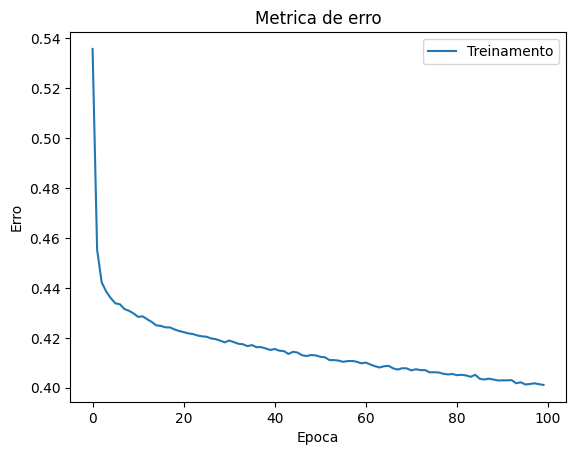


--> Acuracia (treino): 0.8077


In [38]:
from sklearn.metrics import accuracy_score

plt.plot(history.history['loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()

# Obtendo a acuracia no conjunto de treinamento
E_in, acc_train = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)

print(f'\n--> Acuracia (treino): {acc_train:.4f}')




In [39]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=BATCH_SIZE)

Epoch 1/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8051 - loss: 0.4009 - val_accuracy: 0.7889 - val_loss: 0.4251
Epoch 2/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8039 - loss: 0.4011 - val_accuracy: 0.7913 - val_loss: 0.4211
Epoch 3/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8069 - loss: 0.4006 - val_accuracy: 0.7928 - val_loss: 0.4195
Epoch 4/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8070 - loss: 0.4011 - val_accuracy: 0.7947 - val_loss: 0.4198
Epoch 5/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8066 - loss: 0.3996 - val_accuracy: 0.7928 - val_loss: 0.4197
Epoch 6/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8047 - loss: 0.4002 - val_accuracy: 0.7944 - val_loss: 0.4226
Epoch 7/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8073 - loss: 0.4000 - val_accuracy: 0.7956 - val_loss: 0.4250
Epoch 8/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8061 - loss: 0.3995 - val_accu

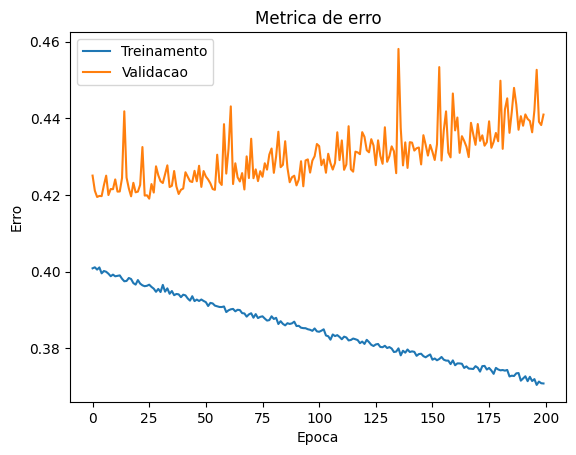

--> E_val - E_in = 0.0745
--> Acuracia (treino): 0.8266
--> Acuracia (validacao): 0.7829
--> acc_train - acc_val = 0.0437


In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

# Obtendo a acuracia no conjunto de treinamento
E_in, acc_train = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)

# Obtendo a acuracia no conjunto de validacao
E_val, acc_val = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE, verbose=0)

print(f"--> E_val - E_in = {E_val - E_in:.4f}")
print(f'--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (validacao): {acc_val:.4f}')
print(f"--> acc_train - acc_val = {acc_train - acc_val:.4f}")

In [41]:

# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=BATCH_SIZE, callbacks=[es])

Epoch 1/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8265 - loss: 0.3702 - val_accuracy: 0.7880 - val_loss: 0.4366
Epoch 2/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8236 - loss: 0.3707 - val_accuracy: 0.7878 - val_loss: 0.4413
Epoch 3/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8238 - loss: 0.3714 - val_accuracy: 0.7828 - val_loss: 0.4415
Epoch 4/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8248 - loss: 0.3708 - val_accuracy: 0.7826 - val_loss: 0.4470
Epoch 5/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8240 - loss: 0.3703 - val_accuracy: 0.7855 - val_loss: 0.4460
Epoch 6/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8235 - loss: 0.3704 - val_accuracy: 0.7874 - val_loss: 0.4364
Epoch 7/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8244 - loss: 0.3697 - val_accuracy: 0.7873 - val_loss: 0.4447
Epoch 8/200
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8240 - loss: 0.3707 - val_accu

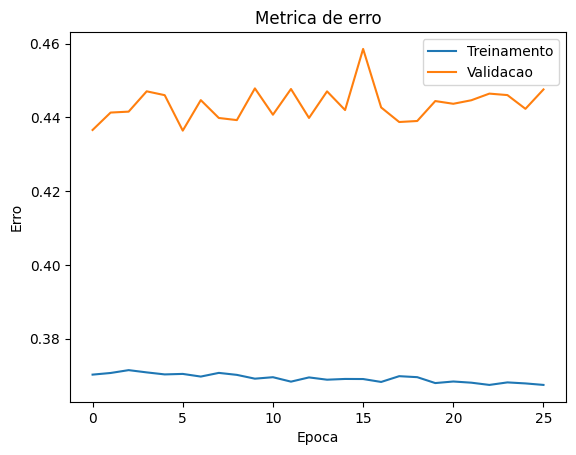

--> E_val - E_in = 0.0832
--> Acuracia (treino): 0.8318
--> Acuracia (validacao): 0.7850
--> acc_train - acc_val = 0.0468


In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

# Obtendo a acuracia no conjunto de treinamento
E_in, acc_train = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)

# Obtendo a acuracia no conjunto de validacao
E_val, acc_val = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE, verbose=0)

print(f"--> E_val - E_in = {E_val - E_in:.4f}")
print(f'--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (validacao): {acc_val:.4f}')
print(f"--> acc_train - acc_val = {acc_train - acc_val:.4f}")

In [ ]:
# Garante o balanceamento nos folds
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True)

accuracies_train = []
accuracies_val = []
history_list = []
ein_list = []
eval_list = []

# Converter y_train para numpy array
y_train_array = y_train.values

# Realiza o k-fold cross validation
i = 0
for train_index, val_index in skf.split(X_train, y_train):
    i = i + 1
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_array[train_index], y_train_array[val_index]
    
    # Criando a arquitetura da rede neural    
    model = Sequential()
    model.add(Dense(64, input_dim=p, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(32, input_dim=p, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))


    # Compilar o modelo
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
  
    # Treina o modelo
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=100, batch_size=BATCH_SIZE, verbose=0)
    history_list.append(history) 
    
    # Avalia o modelo
    E_in, accuracy_train = model.evaluate(X_train_fold, y_train_fold, batch_size=BATCH_SIZE, verbose=0)
    E_val, accuracy_val = model.evaluate(X_val_fold, y_val_fold, batch_size=BATCH_SIZE, verbose=0)
    accuracies_train.append(accuracy_train)
    accuracies_val.append(accuracy_val)
    ein_list.append(E_in)
    eval_list.append(E_val)    
    
    # Exibe o historico de treinamento para um fold especifico
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Metrica de erro - Fold {i}')
    plt.ylabel('Erro')
    plt.xlabel('Epoca')
    plt.legend(['Treinamento'])
    plt.show()

    print(f'--> Acuracia (treino): {accuracy_train:.4f}')
    print(f'--> Acuracia (validacao): {accuracy_val:.4f}')
    print(f"--> E_val - E_in = {E_val - E_in:.4f}")
    print(f"--> acc_in - acc_val = {accuracy_train - accuracy_val:.4f}\n")    

# Calcula a acuracia media
avg_accuracy_train = np.mean(accuracies_train)
avg_accuracy_val = np.mean(accuracies_val)
avg_ein = np.mean(ein_list)
avg_eval = np.mean(eval_list)

# Historico com valores medios dos folds
history_loss_avg = []
history_val_loss_avg = []
aux_list1 = []
aux_list2 = []

for i in range(len(history.history['loss'])):
    for j in range(len(history_list)):
        aux_list1.append(history_list[j].history['loss'][i])
        aux_list2.append(history_list[j].history['val_loss'][i])
    history_loss_avg.append(np.mean(aux_list1))
    history_val_loss_avg.append(np.mean(aux_list2))                            
                   
plt.plot(history_loss_avg)
plt.plot(history_val_loss_avg)
plt.title('Metrica de erro - Media dos Folds')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()

print(f'--> Acuracia (treino): {avg_accuracy_train:.4f}')
print(f'--> Acuracia (validacao): {avg_accuracy_val:.4f}')
print(f"--> E_val - E_in = {avg_eval - avg_ein:.4f}")
print(f"--> acc_in - acc_val = {avg_accuracy_train - avg_accuracy_val:.4f}\n")   

In [45]:
rf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42)
rf.fit(X_train, y_train)


# Previsões
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val)

print('Ein: %0.4f' % (1 - accuracy_score(y_train, rf.predict(X_train))))
print('Eout: %0.4f' % (1 - accuracy_score(y_val, rf.predict(X_val))))
print(classification_report(y_val, rf.predict(X_val)))

Ein: 0.0009
Eout: 0.2016
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      5991
           1       0.69      0.73      0.71      3001

    accuracy                           0.80      8992
   macro avg       0.77      0.78      0.78      8992
weighted avg       0.80      0.80      0.80      8992



In [43]:
n_estimators = [int(x) for x in np.linspace(start=20, stop = 70, num=6)]
max_features = ['sqrt', 'log2', 8]
max_depth = [int(x) for x in np.linspace(start=10, stop = 40, num=4)]
max_depth.append(None)

param_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth
}

In [46]:
from sklearn.model_selection import GridSearchCV

cv_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)

cv_rf.fit(X_train, y_train)

print('Ein: %0.4f' % (1 - accuracy_score(y_train, cv_rf.predict(X_train))))
print('Eout: %0.4f' % (1 - accuracy_score(y_val, cv_rf.predict(X_val))))
print(classification_report(y_val, cv_rf.predict(X_val)))

print(cv_rf.best_estimator_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Ein: 0.1767
Eout: 0.1975
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      5991
           1       0.67      0.81      0.73      3001

    accuracy                           0.80      8992
   macro avg       0.78      0.80      0.79      8992
weighted avg       0.82      0.80      0.81      8992

RandomForestClassifier(max_depth=10, max_features=8, n_estimators=70,
                       random_state=42)


In [47]:
from sklearn.model_selection import RandomizedSearchCV
cv_rf = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 225, cv = 5, verbose=2, n_jobs=-1)

cv_rf.fit(X_train, y_train)

print(cv_rf.best_estimator_)

print('Ein: %0.4f' % (1 - accuracy_score(y_train, cv_rf.predict(X_train))))
print('Eout: %0.4f' % (1 - accuracy_score(y_val, cv_rf.predict(X_val))))
print(classification_report(y_val, cv_rf.predict(X_val)))

C:\Users\luize\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 90 is smaller than n_iter=225. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 90 candidates, totalling 450 fits
RandomForestClassifier(max_depth=10, max_features=8, n_estimators=70,
                       random_state=42)
Ein: 0.1767
Eout: 0.1975
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      5991
           1       0.67      0.81      0.73      3001

    accuracy                           0.80      8992
   macro avg       0.78      0.80      0.79      8992
weighted avg       0.82      0.80      0.81      8992

